In [1]:
import sys

import numpy as np

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

sys.path.append("../../../code/ndsvae/")
import ndsvae as ndsv

sys.path.append("..")
import plot
import util


%matplotlib inline
%load_ext autoreload
%autoreload 2

## Matplotlib config

In [2]:
plt.rcParams['font.family'] = "sans-serif"
plt.rcParams['font.sans-serif'] = "Arial"

SMALL_SIZE = 8
MEDIUM_SIZE = 10
BIGGER_SIZE = 12

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=SMALL_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

## Load data

In [3]:
modelname = "AN"
config = "ns_2_mreg_2_msub_1_nf_32"
testcase = "pmfm_avg"
run = util.select_run(testcase, modelname, config, [0,1])

ds = ndsv.Dataset.from_file(f"../run/main/{testcase}/dataset.npz")
sims = ndsv.GeneratedData.from_file(f"../run/main/{testcase}/model{modelname}/{config}/run{run:02d}/simulations.npz")
params = ndsv.Params.from_file(f"../run/main/{testcase}/model{modelname}/{config}/run{run:02d}/parameters.npz")

In [4]:
model = util.get_model(modelname, config, ds)
model.load_weights(f"../run/main/{testcase}/model{modelname}/{config}/run{run:02d}/fit/model")

In [5]:
# Extend parameters with false parameter - mean value

_thetareg = ds.thetareg

nsub, nreg, nparams = ds.thetareg.shape
ds.thetareg = np.zeros((nsub, nreg, nparams+1))
ds.thetareg[:,:,:nparams] = _thetareg
ds.thetareg[:,:,nparams] = np.mean(ds.y[:,:,0,:], axis=-1)

In [6]:
nsub, nreg, _, nt = ds.y.shape

## Plotting

In [7]:
colors = ['tab:blue', 'tab:red', 'tab:green']


def axbottomleft(ax):
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()

def plot_sketch(ax, path):
    im = plt.imread(path)
    plt.sca(ax1)
    plt.imshow(im, interpolation='none')
    plt.xticks([]); plt.yticks([])
    plt.axis('off')
    
def plot_sc(ax, cax, ds, isub):
    plt.sca(ax)
    plt.title("Structural conn.")
    im = plt.imshow(ds.w[isub], cmap='cividis')
    plt.xticks([])
    plt.yticks([])
    plt.xlabel("Regions")
    plt.ylabel("Regions")
    plt.xticks([])
    
    # plt.colorbar(shrink=0.5, width=0.3)
    plt.colorbar(im, cax=cax, orientation='vertical')
    
def plot_obs_all(ax, t, y, iregs, title=None):
    plt.sca(ax)
    if title:
        plt.title(title)
    plt.imshow(y, aspect='auto', interpolation='none', vmin=-2, vmax=2, cmap='magma')
    plt.yticks([])
    plt.xticks([])
    plt.ylabel("Regions")
    
    for i, ireg in enumerate(iregs):
        plt.scatter(-1, ireg, color=colors[i], marker=5, clip_on=False, s=20, lw=0)
    plt.xlim(0, y.shape[1])    
    
        
def plot_obs_lines(ax, t, ys, labels, offset=4):
    n = len(ys)
    
    plt.sca(ax)
    for i, y in enumerate(ys):
        plt.plot(t, y - offset*i, color=colors[i], lw=1)        
        
    plt.xlim(t[0], t[-1])    
    plt.xlabel("Time")
    plt.xticks([])
    
    plt.ylim(-n*offset, offset)        
    plt.yticks(-offset*np.r_[0:n], labels)
    for ytick, color in zip(ax.get_yticklabels(), colors):
        ytick.set_color(color)
    axbottomleft(ax)
            
        
def plot_fc(ax, cax, y):
    plt.sca(ax)
    plt.title("Functional conn.")
    fc = np.corrcoef(y)
    im = plt.imshow(fc, vmin=-1, vmax=1, cmap='bwr', interpolation='none')
    plt.xticks([])
    plt.yticks([])    
    plt.xlabel("Regions")
    plt.ylabel("Regions")
    plt.colorbar(im, cax=cax, orientation='vertical')
    cax.tick_params(axis=u'y', which=u'both',length=0)

In [25]:
def plot_param2d(ax, pest, ptru=None, param_name=None, lim=None, iregs=None):
    plt.sca(ax)    
        
    if lim is None:
        lim = (0,1)
    cmap = matplotlib.cm.get_cmap('viridis')
    norm = matplotlib.colors.Normalize(vmin=lim[0], vmax=lim[1])
    nreg = pest.shape[0]
    
    if iregs is None:
        iregs = []

    for i in range(nreg):
        lw, zorder = 0.3, i
        if ptru is not None:
            col = cmap(norm(ptru[i]))
        else:
            try:
                col = colors[list(iregs).index(i)]
                zorder = 100
            except ValueError:
                col = 'white' 
        
        plt.scatter(pest[i,0,0], pest[i,1,0], s=10, ec='k', fc=col, lw=0.3, zorder=zorder)
        plt.plot([pest[i,0,0]-pest[i,0,1], pest[i,0,0]+pest[i,0,1]], [pest[i,1,0], pest[i,1,0]],
                 color='k', lw=lw, zorder=zorder)
        plt.plot([pest[i,0,0], pest[i,0,0]], [pest[i,1,0]-pest[i,1,1], pest[i,1,0]+pest[i,1,1]],
                 color='k', lw=lw, zorder=zorder)
            
    plt.xlim(-2,2)
    plt.ylim(-2,2)
    plt.xticks([-2,0,2])
    plt.yticks([-2,0,2])
    plt.xlabel(r"Inferred $\theta^r_{1}$", labelpad=0)
    plt.ylabel(r"Inferred $\theta^r_{2}$", labelpad=0)
    
    if ptru is not None:
        sm = matplotlib.cm.ScalarMappable(cmap=cmap, norm=norm)
        sm.set_array([])
        cbar = plt.colorbar(sm, shrink=0.5, aspect=5, ticks=lim)# , label=param_name)
        cbar.ax.tick_params(axis=u'y', which=u'both',length=0)
        cbar.ax.set_title(param_name, loc='left', pad=7)
    
    
def phaseplot2d(ax, model, c1, c2, x, thetareg, thetasub, u=0., ushared=0., scale=6, color='k'):
    plt.sca(ax)
    fx = ndsv.models.evalf(model, x, thetareg=thetareg, thetasub=thetasub, u=u, ushared=ushared)
    # plt.quiver(x[c1], x[c2], fx[:,:,c1].T, fx[:,:,c2].T, scale=scale, color=color)
    
    if c1 < c2: u, v = fx[:,:,c1].T, fx[:,:,c2].T
    else:       u, v = fx[:,:,c1], fx[:,:,c2]
    
    plt.streamplot(x[c1], x[c2], u, v, density=0.5, linewidth=0.5, arrowsize=0.25, color=color)
    
    velocity = np.sqrt(u**2 + v**2)
    plt.imshow(velocity, cmap='plasma', extent=[x[c1][0], x[c1][-1], x[c2][0], x[c2][-1]], origin='lower',
               alpha=0.5, zorder=-1, vmin=0, vmax=3)


def plot_phaseplot(ax, model, x, treg, tsub, nquiver=10, color='k', label=None, xlabels=True, ylabels=True):    
    plt.sca(ax)
    rng = (-2., 2.)
    
    for i in range(x.shape[0]):
        plt.plot(x[i,0], x[i,1], color='yellow', alpha=1, lw=0.5, zorder=10)
    
    xq = [0. for _ in range(model.ns)]
    xq[0] = np.linspace(rng[0], rng[1], nquiver)
    xq[1] = np.linspace(rng[0], rng[1], nquiver)
    phaseplot2d(ax, model, 0, 1, x=xq, thetareg=treg, thetasub=tsub, u=0., ushared=0., scale=20, color='k')
    plt.xlim(rng); plt.ylim(rng)
    
    plt.xticks([-2,0,2], None if xlabels else ["","",""])
    if xlabels: plt.xlabel(f"$x_1$", labelpad=0)
        
    plt.yticks([-2,0,2], None if ylabels else ["","",""])
    if ylabels: plt.ylabel(f"$x_2$", labelpad=0)
    
    if label:
        plt.text(0.04, 0.96, label, ha='left', va='top', transform=ax.transAxes, color=color, fontsize=8,
                 bbox=dict(boxstyle='square', facecolor='white', alpha=0.85))
        
    for pos in ['bottom', 'top', 'right', 'left']:
        ax.spines[pos].set_color(color)
        ax.spines[pos].set_linewidth(1.5)
    ax.tick_params(axis='both', colors=color)
    ax.xaxis.label.set_color(color)
    ax.yaxis.label.set_color(color)    
    
    
    
def plot_params(ax, x, label, lim, cax=None):
    plt.sca(ax)
    im = plt.imshow(x[:,None], interpolation='None', cmap='viridis', vmin=lim[0], vmax=lim[1], aspect='auto')
    plt.xticks([])
    plt.yticks([])
    plt.ylabel(label)
    ax.yaxis.set_label_position("right")
    
    if cax is not None:
        plt.colorbar(im, cax=cax, orientation='vertical', ticks=lim, pad=0)
        cax.tick_params(axis=u'y', which=u'both',length=0)

In [26]:
def plot_mfm(ax):
    plt.sca(ax)
    
    s = np.linspace(0, 0.7, 300)    
    
    wp = 1.0    
    tau_s = 100
    gamma = 0.641/1000.
    Jn = 0.2609

    a = 270.
    b = 108.
    d = 0.154
    h = lambda x: (a*x - b) / (1 - np.exp(-d*(a*x - b)))
    Io = 0.295    
    
    for In, ls, pos in zip([0.0, 0.027, 0.045], ['-', '-', '-'], [(0.24,-0.002), (0.32, -0.001), (0.35, 0.0017)]):
        x = wp*Jn*s + Io + In
        sdot = -s/tau_s + (1. - s)*gamma*h(x)
        plt.plot(s, sdot, color='k', ls=ls, lw=1)
        
        plt.text(pos[0], pos[1], f"$I_n = {In:0.3f}$", fontsize=7,
                 bbox=dict(facecolor='w', edgecolor='k', lw=0.3, pad=1))
    
    # plt.legend(title="Io", ncol=3)
    plt.xlabel("$S$", labelpad=5)
    plt.ylabel("$\dot{S}$", labelpad=0)
    plt.axhline(0, color='0.5', ls='--', zorder=-1, lw=0.7)
    plt.ylim(-0.0025, 0.0025)
    plt.xticks([0., 0.3, 0.6])
    axbottomleft(ax)
        

# plt.figure(figsize=(2,1), dpi=200)
# plot_mfm(plt.gca())

In [27]:
def plot_observations(fig, pos, t, y, examples, tzoom):
    left, right, bottom, top = pos
    
    gs = fig.add_gridspec(nrows=2, ncols=2, height_ratios=[2,1], width_ratios=[2,1.4],
                          left=left, right=right, bottom=bottom, top=top, hspace=0.6, wspace=0.3)
    ax1 = plt.subplot(gs[0,0])
    plot_obs_all(ax1, t, y, examples, title="Timeseries")

    ax2 = plt.subplot(gs[1,0])
    plot_obs_lines(ax2, t, y[examples], labels=['A', 'B', 'C'], offset=4)
    plt.xlim(0,864)
    
    plt.plot([60, 180], [5,5], lw=2, color='k', clip_on=False)
    plt.text(120, 6, "120 s", ha='center', va='bottom', clip_on=False, fontsize=8)
    plt.plot([tzoom[0], tzoom[1], tzoom[1], tzoom[0], tzoom[0]], [3, 3, -11, -11, 3], color='0.5', lw=0.8)

    ax3 = plt.subplot(gs[0,1])
    box = ax3.get_position()
    cax3 = fig.add_axes([box.x0+box.width+0.005,box.y0+0.2*box.height,0.007,0.6*box.height])
    plot_fc(ax3, cax3, y)

    ax4 = plt.subplot(gs[1,1])
    plot_obs_lines(ax4, t, y[examples], labels=['A', 'B', 'C'], offset=4)
    plt.xlim(tzoom)
    
    plt.plot([tzoom[0] + 10, tzoom[0] + 20], [5, 5], lw=2, color='k', clip_on=False)
    plt.text(tzoom[0] + 15, 6, "10 s", ha='center', va='bottom', clip_on=False, fontsize=8)

In [28]:
def plot_param1d(ax, ptru, pest, xlabel, ylabel, example=None):
    nsub = len(ptru)
    
    plt.sca(ax)
    
    for i in range(nsub):
        plt.plot([ptru[i], ptru[i]], [pest[i,0]-pest[i,1], pest[i,0]+pest[i,1]], color='k', lw=0.7, zorder=10)
        plt.scatter(ptru[i], pest[i,0], fc=('0.5' if i == example else 'white'), ec='k', lw=0.4, s=15)
    
    plt.xlabel(xlabel, labelpad=2)
    plt.ylabel(ylabel, labelpad=0)
    plt.ylim(-0.3, 0.3)
    plt.xticks([0.16, 0.20])

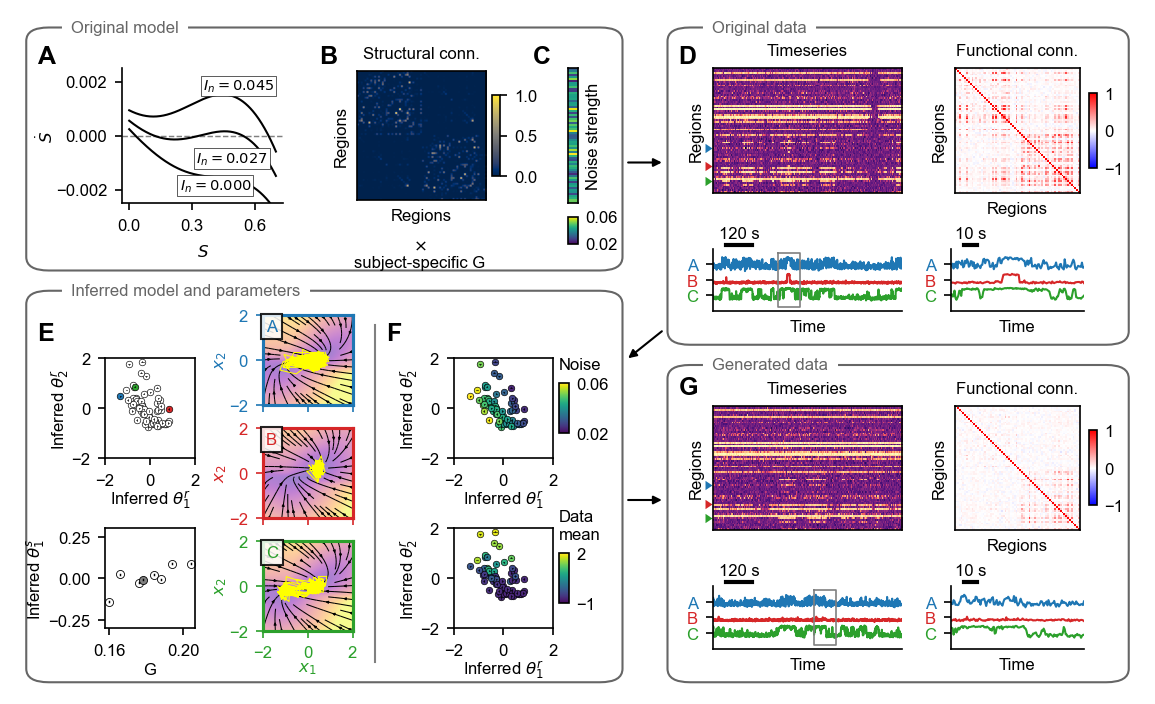

In [29]:
isub = 2
iregs = [43, 53, 61]
isample = 34

t = (ds.t[-nt:] - ds.t[-nt])/1000. # in miliseconds


fig = plt.figure(figsize=(7.5, 4.5), dpi=150)

# Top left ----------------------------
gs1 = fig.add_gridspec(nrows=1, ncols=5, left=0.095, right=0.50, bottom=0.72, top=0.92,
                       width_ratios=[2,-0.1,1.6,0.0,0.12], wspace=0.7)
ax1 = plt.subplot(gs1[0])
ax2 = plt.subplot(gs1[2])
ax3 = plt.subplot(gs1[4])

box = ax2.get_position(); cax2 = fig.add_axes([box.x0+box.width+0.005,box.y0+0.2*box.height,0.007,0.6*box.height])
box = ax3.get_position(); cax3 = fig.add_axes([box.x0, box.y0-0.3*box.height, box.width, 0.2*box.height])

plot_mfm(ax1)
plot_sc(ax2, cax2, ds, isub)
plot_params(ax3, ds.thetareg[isub,:,0], "Noise strength", (0.02,0.06), cax=cax3)

# Bottom left --------------------------
gs3a = fig.add_gridspec(nrows=2, ncols=1, left=0.08, right=0.16, top=0.49, bottom=0.09, hspace=0.7)
gs3b = fig.add_gridspec(nrows=3, ncols=1, left=0.22, right=0.30, top=0.56, bottom=0.08, hspace=0.15)
gs3c = fig.add_gridspec(nrows=2, ncols=1, left=0.39, right=0.50, top=0.49, bottom=0.09, hspace=0.7)

plot_param2d(plt.subplot(gs3a[0]), params.thetareg[isub], iregs=iregs)
plot_param1d(plt.subplot(gs3a[1]), ds.thetasub[:,0], params.thetasub[:,0,:], "G", r"Inferred $\theta^s_1$",
             example=2)

for i, (ireg, color, label) in enumerate(zip(iregs, colors, ['A','B','C'])):
    plot_phaseplot(plt.subplot(gs3b[i]), model, sims.x[isample:isample+1,isub,ireg,:,-int(0.75*nt):-int(0.5*nt)],
                   treg=params.thetareg[isub,ireg,:,0], tsub=params.thetasub[isub,:,0],
                   color=color, label=label, xlabels=(i == 2), nquiver=100)


plot_param2d(plt.subplot(gs3c[0]), params.thetareg[isub], ptru=ds.thetareg[isub,:,0], param_name="Noise",
             lim=[0.02, 0.06])
plot_param2d(plt.subplot(gs3c[1]), params.thetareg[isub], ptru=ds.thetareg[isub,:,3], param_name="Data\nmean",
             lim=[-1,2])

# Top and bottom right ---------------------------
plot_observations(fig, (0.62, 0.95, 0.56, 0.92), t, ds.y[isub,:,0,-nt:],           iregs, (300,400))
plot_observations(fig, (0.62, 0.95, 0.06, 0.42), t, sims.y[isample,isub,:,0,-nt:], iregs, (460,560))

# =======================================================================

bg = plot.Background(visible=False)
bg.labels([0.02, 0.27, 0.46, 0.59, 0.02, 0.33, 0.59],
          [0.92, 0.92, 0.92, 0.92, 0.51, 0.51, 0.43], fontsize=12)

plot.box_rounded(bg.axes, [0.03, 0.52, 0.64, 0.96], pad=0.02, title="Original model")
plot.box_rounded(bg.axes, [0.60, 0.97, 0.53, 0.96], pad=0.02, title="Original data")
plot.box_rounded(bg.axes, [0.03, 0.52, 0.03, 0.57], pad=0.02, title="Inferred model and parameters")
plot.box_rounded(bg.axes, [0.60, 0.97, 0.03, 0.46], pad=0.02, title="Generated data")
bg.vline(x=0.32, y0=0.04, y1=0.54)

prop = dict(arrowstyle="-|>,head_width=0.2,head_length=0.4", shrinkA=0,shrinkB=0, ec='k', fc='k')
plt.annotate("", xytext=(0.545, 0.78), xy=(0.575, 0.78), arrowprops=prop)
plt.annotate("", xytext=(0.575, 0.53), xy=(0.545, 0.49), arrowprops=prop)
plt.annotate("", xytext=(0.545, 0.28), xy=(0.575, 0.28), arrowprops=prop)

bg.axes.text(0.36, 0.645, "$\\times$\nsubject-specific G", fontsize=8, ha='center', va='center')

plt.savefig(f"img/Fig_pMFM_model{modelname}.pdf")